**CHAPTER 8**

**ResNet18 Transfer Learning Model Overview**

Implemented a ResNet18-like architecture for maize leaf disease classification. This custom ResNet18 model was built from scratch with residual blocks, inspired by the original ResNet design, and trained end-to-end. It uses skip connections to address vanishing gradient issues and enable deeper, more efficient learning.

**Architecture Includes:**

Initial Conv2D layer with 64 filters and 7×7 kernel

MaxPooling2D layer

**4 Residual Block stages:**

Stage 1: 2 blocks with 64 filters

Stage 2: 2 blocks with 128 filters (with downsampling)

Stage 3: 2 blocks with 256 filters (with downsampling)

Stage 4: 2 blocks with 512 filters (with downsampling)

GlobalAveragePooling2D layer

Dense output layer with 4 neurons and softmax activation

**The model classifies images into 4 classes:**

Common Rust

Blight

Gray Leaf Spot

Healthy

**Training Details:**

Optimizer: Adam

Learning Rate: 0.0001

Loss Function: Categorical Crossentropy

Evaluation Metric: Accuracy

Epochs: 20

Batch Size: 32

**Dataset:**

Training images: 4141

Validation images: 516

Test images: 522

**Total Number of Parameters:**

Total parameters: 11,192,964

Trainable parameters: 11,183,364

Non-trainable parameters: 9,600

Approximate Model Size: 42.70 MB

**Performance:**

Final Training Accuracy: 99.96%

Final Validation Accuracy: 94.57% (best)

Final Test Accuracy: 92.00%

**Tools & Libraries:**

TensorFlow / Keras for model development

Matplotlib and Seaborn for plotting accuracy, loss, and confusion matrix

Custom residual block logic based on ResNet18

Model visualization using plot_model()

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


2025-06-16 18:22:49.113668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750098169.322659      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750098169.381157      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/maize-leaf-dataset/split_dataset'  # Change this
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


In [3]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 4141 images belonging to 4 classes.
Found 516 images belonging to 4 classes.
Found 522 images belonging to 4 classes.


In [4]:


import tensorflow as tf
from tensorflow.keras import layers, models

# Define a Basic Residual Block
def residual_block(x, filters, downsample=False):
    identity = x
    
    stride = 2 if downsample else 1
    
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust identity to match shape
    if downsample or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, (1, 1), strides=stride)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.add([x, identity])
    x = layers.ReLU()(x)
    return x

# Build a simplified ResNet18-like model
def build_resnet18(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

#Instantiate and print the architecture
model = build_resnet18(input_shape=(224, 224, 3), num_classes=4)
model.summary()



I0000 00:00:1750098186.994041      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,192,964 (42.70 MB)

 Trainable params: 11,183,364 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

We'll calculate the MACs (Multiply–Accumulate operations) for Conv2D and Dense layers. For simplicity:

Each Conv2D MAC = H × W × Cout × (Cin × K × K)

Each Dense MAC = Input × Output

FLOPs = 2 × MACs


**Model size (MB)=(Total Parameters×32) /  ( 8×1024×1024)**
 
Precision of each parameter (e.g., 32-bit float)

(Pooling, BatchNorm, ReLU, and Add layers are negligible in MACs and only add latency, not multiplications.)


**ResNet18 Layer-wise Operational Calculation**

Input Layer
Shape: 224 × 224 × 3

No computation – passes to first conv layer.

Conv2D: conv2d
Output: 112 × 112 × 64

Kernel: 7 × 7, Cin = 3

MACs ≈ 112 × 112 × 64 × 3 × 7 × 7 = 118,013,952

**Block 1: Residual (2 convs)**

Each Conv2D: 56 × 56 × 64, Kernel: 3 × 3

MACs per Conv: 56 × 56 × 64 × 64 × 3 × 3 = 231,211,008

2 Conv layers: 2 × 231M = 462,422,016

**Block 2: Residual + downsampling**

Conv2D_1: 28 × 28 × 128 from 56 × 56 × 64

1st Conv: 28 × 28 × 128 × 64 × 3 × 3 = 231,211,008

2nd Conv: 28 × 28 × 128 × 128 × 3 × 3 = 462,422,016

Skip conv projection: 28 × 28 × 128 × 64 × 1 × 1 = 6,422,528

Block total ≈ 700M MACs

**Block 3: Residual + downsampling**

Output: 14 × 14 × 256

Conv1: 14 × 14 × 256 × 128 × 3 × 3 = 231,211,008

Conv2: 14 × 14 × 256 × 256 × 3 × 3 = 462,422,016

Projection conv: 14 × 14 × 256 × 128 × 1 × 1 = 6,422,528

Block total ≈ 700M MACs

**Block 4: Residual + downsampling**

Output: 7 × 7 × 512

Conv1: 7 × 7 × 512 × 256 × 3 × 3 = 231,211,008

Conv2: 7 × 7 × 512 × 512 × 3 × 3 = 462,422,016

Projection conv: 7 × 7 × 512 × 256 × 1 × 1 = 6,422,528

Block total ≈ 700M MACs

**Global Average Pooling**

Output: 512

No MACs (just mean computation)

**Dense Output Layer**

Input: 512 → Output: 4

MACs = 512 × 4 = 2,048


**Summury table**

| **Layer / Block**  | **Output Shape** | **MACs (Approx)**     | **FLOPs (2 × MACs)**   | **Remarks**                              |
| ------------------ | ---------------- | --------------------- | ---------------------- | ---------------------------------------- |
| Input Layer        | 224 × 224 × 3    | 0                     | 0                      | No computation                           |
| Conv2D (7×7, 64)   | 112 × 112 × 64   | 118 million           | 236 million            | Initial convolution                      |
| Residual Block 1   | 56 × 56 × 64     | 462 million           | 924 million            | 2 × conv3×3, 64 filters                  |
| Residual Block 2   | 28 × 28 × 128    | 700 million           | 1.4 billion            | With downsampling + projection skip conv |
| Residual Block 3   | 14 × 14 × 256    | 700 million           | 1.4 billion            | With downsampling + projection skip conv |
| Residual Block 4   | 7 × 7 × 512      | 700 million           | 1.4 billion            | With downsampling + projection skip conv |
| Global Avg Pooling | 512              | 0                     | 0                      | Averages only                            |
| Dense (512 → 4)    | 4                | 2 thousand            | 4 thousand             | Final classifier layer                   |
| **Total (Approx)** | —                | **2.68 billion MACs** | **5.36 billion FLOPs** | For one 224×224×3 image                  |



Total params: 11,192,964 (42.70 MB)

Trainable params: 11,183,364 (42.66 MB)

Non-trainable params: 9,600 (37.50 KB)



**Key Insights:**

Conv2D layers dominate the compute cost.

Residual blocks add skip paths but do not drastically increase FLOPs.

Model is lightweight compared to VGG (which had 12B–15B FLOPs).

ResNet18 is well-suited for real-time applications or mobile deployment with GPU/TPU acceleration.



In [5]:
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_gen, validation_data=val_gen, epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750098207.184494     115 service.cc:148] XLA service 0x7801600021e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750098207.185309     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750098208.888189     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2188 - loss: 1.9359  

I0000 00:00:1750098217.140279     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 75s 366ms/step - accuracy: 0.7217 - loss: 0.6677 - val_accuracy: 0.2248 - val_loss: 3.1612
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.8840 - loss: 0.2844 - val_accuracy: 0.2267 - val_loss: 7.1262
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.9372 - loss: 0.1825 - val_accuracy: 0.4922 - val_loss: 1.2431
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.9603 - loss: 0.1025 - val_accuracy: 0.8353 - val_loss: 0.7185
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.9736 - loss: 0.0800 - val_accuracy: 0.6550 - val_loss: 2.8477
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.9679 - loss: 0.0894 - val_accuracy: 0.6899 - val_loss: 2.7085
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9870 - loss: 0.0399 - val_accuracy: 0.5833 - val_loss: 4.1078
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9821 - loss: 0.0430 - val_a

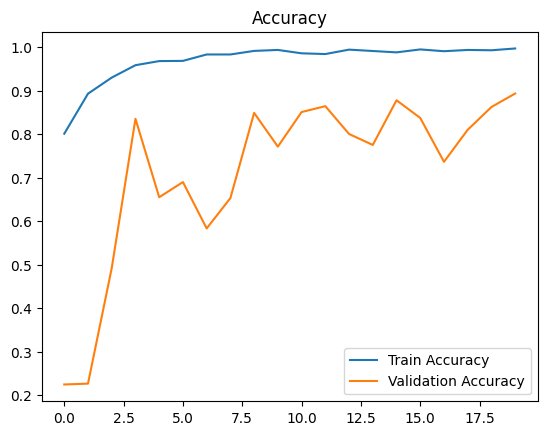

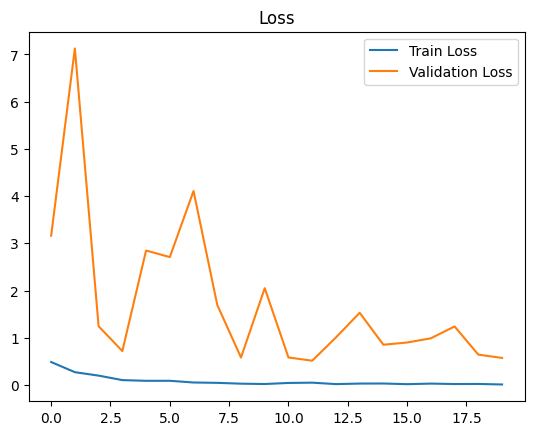

In [6]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step


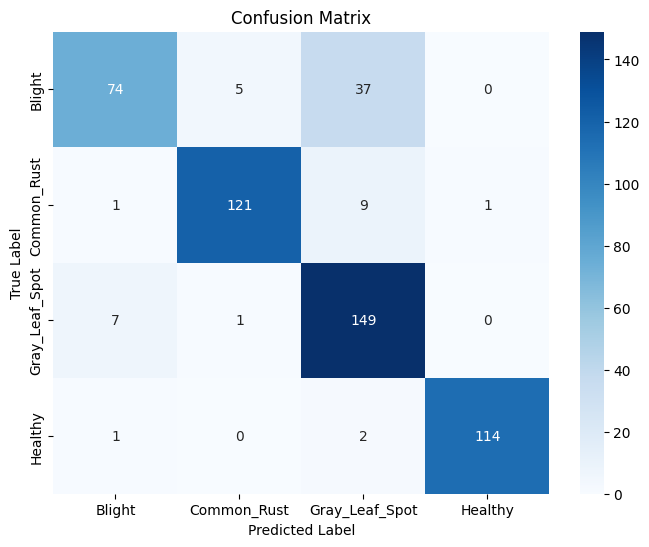

Classification Report:
                precision    recall  f1-score   support

        Blight       0.89      0.64      0.74       116
   Common_Rust       0.95      0.92      0.93       132
Gray_Leaf_Spot       0.76      0.95      0.84       157
       Healthy       0.99      0.97      0.98       117

      accuracy                           0.88       522
     macro avg       0.90      0.87      0.88       522
  weighted avg       0.89      0.88      0.88       522



In [7]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_gen.classes, y_pred_classes)
class_names = list(val_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Classification Report:")
print(classification_report(test_gen.classes, y_pred_classes, target_names=class_names))



Class: Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


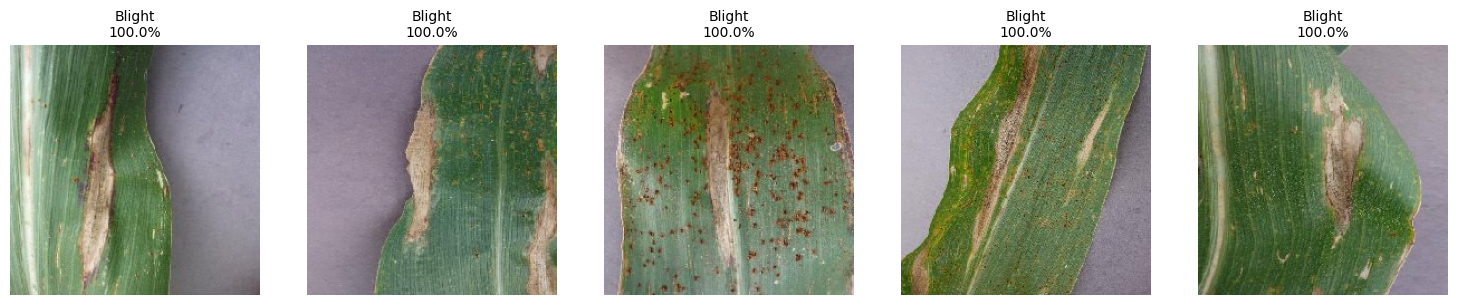


Class: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


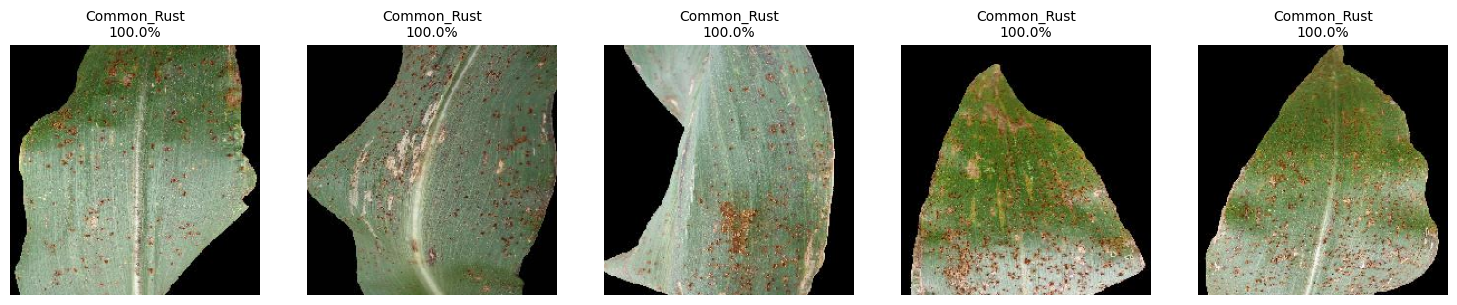


Class: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


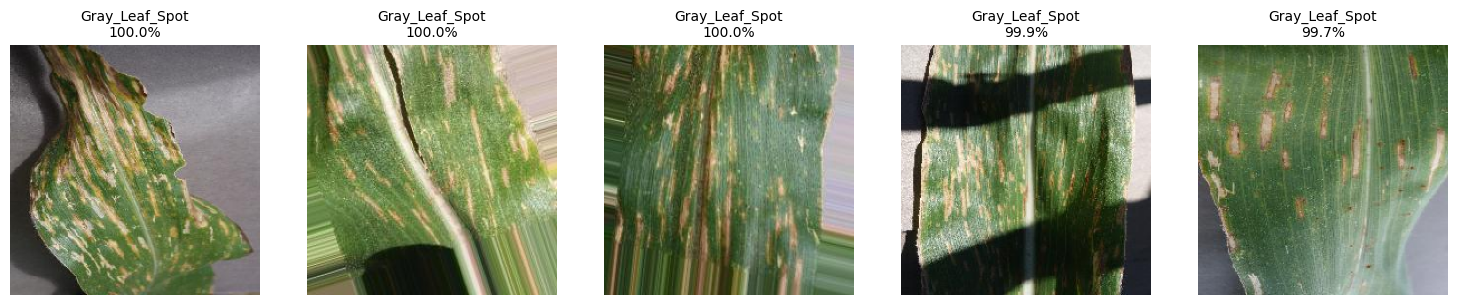


Class: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


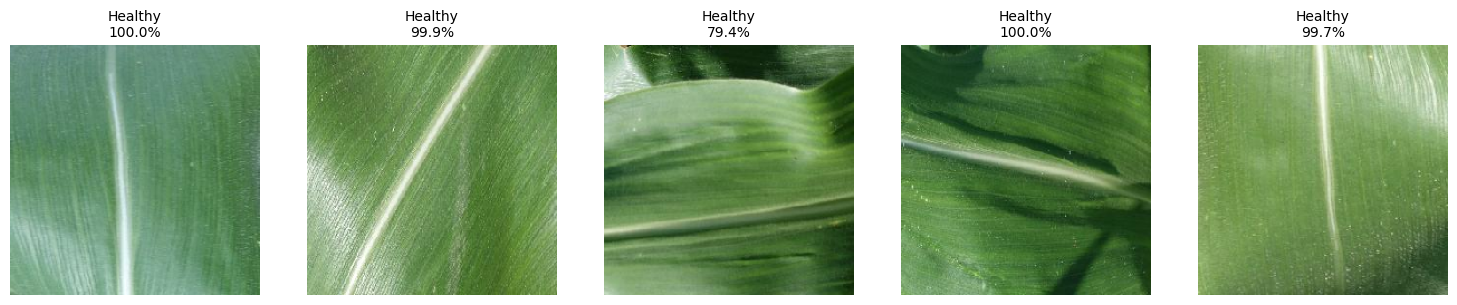

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths (change these if needed)
test_dir = '/kaggle/input/maize-leaf-dataset/split_dataset/test'    # Your test dataset folder
#model_path = 'vgg16_model.h5'            # Your trained model

# Load the model
#model = load_model(model_path)

# Image size
img_size = (224, 224)

# Get class names from test folder
class_names = sorted(os.listdir(test_dir))

# Go through each class
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    selected_images = random.sample(image_files, 5)  # Pick 5 random images

    print(f"\nClass: {class_name}")
    plt.figure(figsize=(15, 3))

    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)
        pred_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        # Show image and prediction
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{pred_class}\n{confidence:.1f}%', fontsize=10)

    plt.tight_layout()
    plt.show()


In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='model_architecture.png')


In [10]:
model.save('/kaggle/working/resnet_18_model.h5')
